In [15]:
import numpy as np
import torch
import torch.nn as nn
from torch.cuda import amp
from tqdm import tqdm
import torchvision
from tensorflow.keras.datasets import mnist
import torch.nn.functional as F
import matplotlib.pyplot as plt
import denoise
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


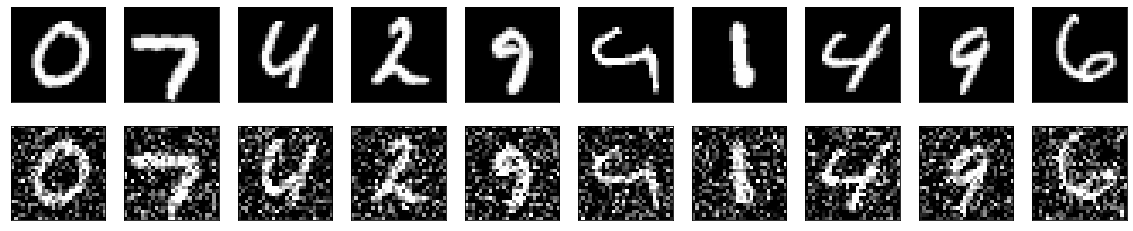

In [3]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [4]:
class AverageMeter:

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
class DenoisingDataset:
    
    def __init__(self, features, targets=None):
        self.features = features
        self.targets = targets
     
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = features.transpose(2, 0, 1)
        targets = targets.transpose(2, 0, 1)

        return {
            "features": torch.tensor(features, dtype=torch.float32),
            "targets": torch.tensor(targets, dtype=torch.float32),
        }

In [46]:
class Trainer(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = None
        self.fp16 = False
     
    def forward(self, *args, **kwargs):
        super().forward(*args, **kwargs)
        
    def fetch_optimizer(self, *args, **kwargs):
        return
        
    def fetch_scheduler(self, *args, **kwargs):
        return        

    def train_one_epoch(self, dataloader):
        self.train()
        losses = AverageMeter()
        tk0 = tqdm(dataloader, total=len(dataloader))
        for idx, data in enumerate(tk0):
            logit, loss = self.train_one_step(data)
            losses.update(loss.item(), dataloader.batch_size)
            tk0.set_postfix(loss=losses.avg, stage='train')
        tk0.close()
        return losses.avg
    
    def train_one_step(self, data):
        self.optimizer.zero_grad()
        for k, v in data.items():
            data[k] = v.to('cuda')
        with torch.set_grad_enabled(True):
            if self.fp16:
                with amp.autocast():    
                    logit, loss = self(**data)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
            else:
                logit, loss = self(**data)
                loss.backward()
                self.optimizer.step()
        return logit, loss
    
    def validate_one_epoch(self, dataloader):
        self.eval()
        losses = AverageMeter()
        tk0 = tqdm(dataloader, total=len(dataloader))
        for idx, data in enumerate(tk0):
            logit, loss = self.validate_one_step(data)
            losses.update(loss.item(), dataloader.batch_size)
            tk0.set_postfix(loss=losses.avg, stage='valid')
        tk0.close()
        return losses.avg
    
    def validate_one_step(self, data):
        for k, v in data.items():
            data[k] = v.to('cuda')
        logit, loss = self(**data)
        return logit, loss
    
    def predict(self, dataset, batch_size, device):
        self.eval()
        if next(self.parameters()).device!=device:
            self.to(device)
        predictions = []
        dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0
        )
        
        tk0 = tqdm(dataloader, total=len(dataloader))
        for idx, data in enumerate(tk0):
            logit = self.predict_one_step(data)
            predicted = logit.cpu().numpy()
            predictions.append(predicted)
        tk0.close()
        return np.concatenate(predictions)
    
    def predict_one_step(self, data):
        for k, v in data.items():
            data[k] = v.to('cuda')
        with torch.no_grad():        
            logit, _ = self(**data)
        return logit
    
    
    def fit(self, train_dataset, valid_dataset, epochs=1):

        train_loader = torch.utils.data.DataLoader(
                                        train_dataset,
                                        batch_size=64,
                                        shuffle=True,
                                        num_workers=4,
                                        pin_memory=True
        )
        valid_loader = torch.utils.data.DataLoader(
                                        valid_dataset,
                                        batch_size=64,
                                        shuffle=True,
                                        num_workers=4,
                                        pin_memory=True
        )
        self.optimizer = self.fetch_optimizer()
        self.scheduler = self.fetch_scheduler()
        self.to('cuda')
        for epoch in range(epochs):
            loss = self.train_one_epoch(train_loader)
            loss = self.validate_one_epoch(valid_loader)
            self.scheduler.step()

In [47]:
class DenoisingAutoEncoder(Trainer):
    
    def __init__(self):
        super(DenoisingAutoEncoder, self).__init__()
                  
        self.encoder = nn.Sequential(
                                     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
                                     nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=2, padding=0),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=(2, 2), stride=2, padding=0),
                                     nn.ReLU(inplace=True),    
                                     nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=1),
                                     nn.Sigmoid()
                                
        )
        
    
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        return opt

    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
             self.optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1
         )
        return sch
        
    def forward(self, features, targets=None):
        x = self.encoder(features)
        x = self.decoder(x)
        loss=None
        
        if targets is not None:
            loss = nn.MSELoss()(x, targets)
            
        return x, loss

In [43]:
train_dataset = DenoisingDataset(noisy_train_data, train_data)
valid_dataset = DenoisingDataset(noisy_test_data, test_data)
model = DenoisingAutoEncoder()
model.fit(train_dataset, valid_dataset, epochs=10)

100%|█████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.80it/s, loss=0.00942, stage=valid]


In [44]:
predictions = model.predict(valid_dataset, batch_size=16, device='cuda')

100%|█████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:02<00:00, 523.52it/s]


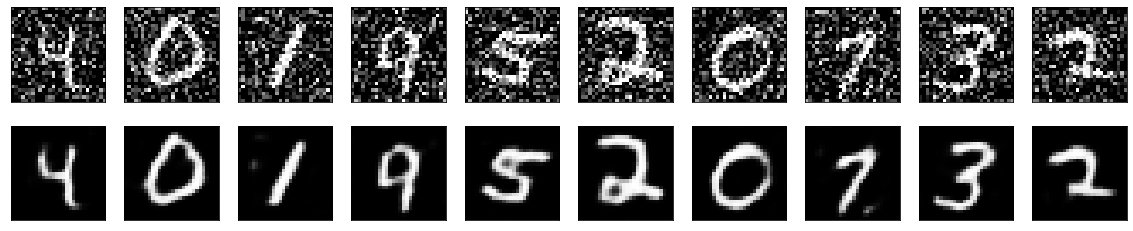

In [45]:
display(noisy_test_data, predictions)